In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Загрузим файл с признаками

In [3]:
features = pd.read_excel('C:\\Users\\dgalk\\shad_final_project\\features_region_3.xlsx')

Посмотрим на него

In [4]:
features.drop(['Unnamed: 0'], axis=1, inplace=True)
features.head()

,BrickCode,VRP,APT,PCP,PHK,PHN,PST,top_brand_0,top_brand_1,top_brand_2,...,debcred,pens_proc,prod_basket,pharm_basket,num_pharm,region_popul,soul_on_pharm,Basket1,Basket2,Basket3
0,800256,370610,76,91,19,527,0,171,81,0,...,897269895,0.507913,14991.045294,6234.436471,1299,2248044,1730.595843,5.265847e+09,4.446332e+09,5.823915e+08
1,800257,370610,118,115,36,317,0,191,50,0,...,897269895,0.507913,14991.045294,6234.436471,1299,2248044,1730.595843,2.947553e+09,2.601573e+09,2.293148e+08
2,800258,402640,14,20,5,257,1,38,51,0,...,430444463,0.424295,15472.650000,6268.832941,593,1196147,2017.111298,2.278795e+09,2.005747e+09,2.232369e+08
3,800259,402640,25,47,10,213,1,71,24,0,...,430444463,0.424295,15472.650000,6268.832941,593,1196147,2017.111298,1.697367e+09,1.537390e+09,1.277860e+08
4,800260,418370,9,56,11,168,0,37,72,35,...,444532469,0.503268,17496.211765,6080.499412,641,1079053,1683.390016,1.096860e+09,9.745093e+08,1.048994e+08


Полный список признаков

In [5]:
col_full = ['VRP', 
            'APT', 'PCP', 'PHK', 'PHN', 'PST',
            'top_brand_0', 'top_brand_1', 'top_brand_2', 'top_brand_7',
            'top_brand_10', 'top_brand_11', 'top_brand_14', 'top_brand_17',
            'top_brand_31', 'top_brand_84',
            'top_sales_0', 'top_sales_1', 'top_sales_7', 'top_sales_9',
            'top_sales_10', 'top_sales_11', 'top_sales_14', 'top_sales_17',
            'top_sales_31', 'top_sales_32', 'top_sales_34', 'top_sales_39', 
            'top_sales_41', 'top_sales_84', 'top_sales_133', 
            'Rate1', 'Rate2', 'Rate3', 
            'weekdays_work_time', 'weekend_work_time', 'is_work_time_almost_24_7', 
            #'uniq_sku_mean_median3', 
            'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3',
            'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 
            #'sell_mean_median3', 
            'sell_mean_summer_median3', 'sell_mean_autumn_median3', 
            'sell_mean_winter_median3', 'sell_mean_spring_median3', 
            #'avg_sell_sku_median3',
            'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 
            'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3',
            'debcred', 'pens_proc', 'prod_basket', 'pharm_basket',
            'num_pharm', 'region_popul', 'soul_on_pharm'
]

BrickCode с хорошим прогнозом

In [6]:
brickcode_ok = [800100, 800101, 800102, 800104, 800106, 800109, 800112,
                800113, 800114, 800115, 800117, 800118, 800119, 800121,
                800125, 800126, 800127, 800171, 800176, 800178, 800180,
                800181, 800182, 800184, 800185, 800186, 800187, 800188,
                800189, 800190, 800204, 800206, 800208, 800210, 800213, 
                800215, 800231, 800232, 800239, 800242, 800243, 
                800244, 800245, 800252, 800253, 800260, 800262, 800263,
                800264, 800266, 800267, 800278, 800280, 800281, 800282, 
                800286, 800287, 800288, 800293, 800294, 800297, 800298,
                800299, 800300, 800302, 800304, 800305, 800307, 800309,
                800310, 800312, 800314, 800317,]

BrickCode, которые предсказываем

In [7]:
brickcode_bad = list(set(features.BrickCode.unique()) - set(brickcode_ok))

# Выделим train

In [8]:
features.index = features.BrickCode

In [9]:
train = features.loc[brickcode_ok, :]

In [10]:
X = train[col_full]
y = train[['Basket1', 'Basket2', 'Basket3']]

Посмотрим на данные

In [11]:
def plot_hist(data, title=''):
    fig = plt.figure(figsize = (10,5))
    ax = fig.gca()
    data.plot.hist(grid=True, bins=20, ax=ax, rwidth=0.9, color='#607c8e')
    ax.set_title(title, fontsize=20)
    ax.set_ylabel('Частоты', fontsize=20)
    ax.set_xlabel('Объем корзины', fontsize=20)  

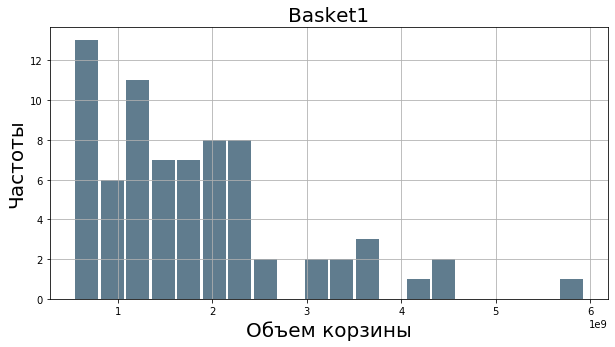

In [12]:
plot_hist(y['Basket1'], 'Basket1')

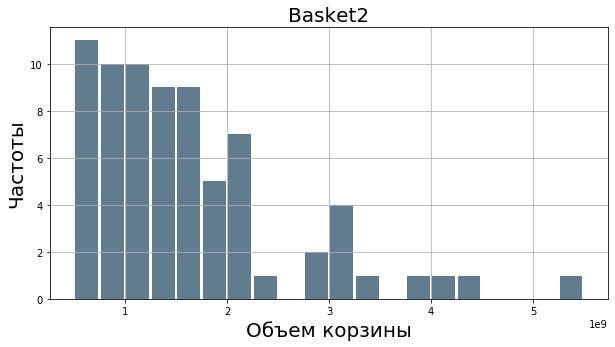

In [13]:
plot_hist(y['Basket2'], 'Basket2')

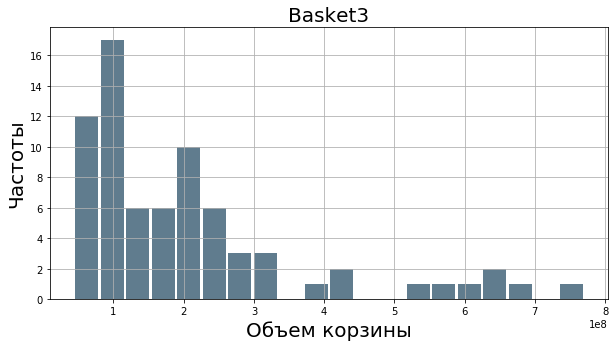

In [14]:
plot_hist(y['Basket3'], 'Basket3')

In [15]:
def plot_graphic_sorted(y, figsize=(10,5), linewidth=4, color=['tab:brown',], label=['',]):
    fig, ax = plt.subplots(figsize=figsize)
    i = 0
    for col in y.columns:
        indices = np.argsort(y[col])
        x_plt = np.arange(0, y[col].size)
        y_plt = y[col].iloc[indices]  
        ax.plot(x_plt, y_plt, color=color[i], linewidth=linewidth, label=label[i])
        ax.grid(linestyle='--')
        ax.legend()
        i += 1

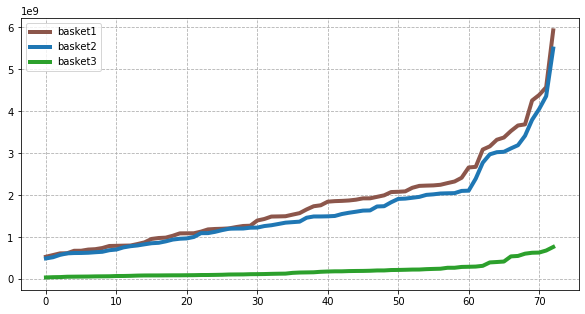

In [16]:
plot_graphic_sorted(y, 
                    color=['tab:brown', 'tab:blue', 'tab:green'],
                    label=['basket1', 'basket2', 'basket3'])

1-ая и 2-ая корзина одинаковые, 3-ья существенно меньше

# 1-ый прогон, Basket1
Применим RandomForest и посмотрим на значимые признаки, т.к. их много сейчас. 

Пока никак не оцениваем качество

In [17]:
rf_regr = RandomForestRegressor(max_depth=3, random_state=0)
rf_regr.fit(X, y['Basket1'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

### Значимость признаков

In [18]:
def get_and_draw_importances(X_train, importances, figsize=(10,20)):
  indices = np.argsort(importances)
  plt.figure(figsize=figsize)
  plt.title("Feature importances")
  plt.barh(range(X_train.shape[1]), importances[indices], color="r", align="center")
  plt.yticks(range(X_train.shape[1]), X_train.columns[indices])
  plt.ylim([-1, X_train.shape[1]])
  plt.show()
  return X_train.columns[indices]

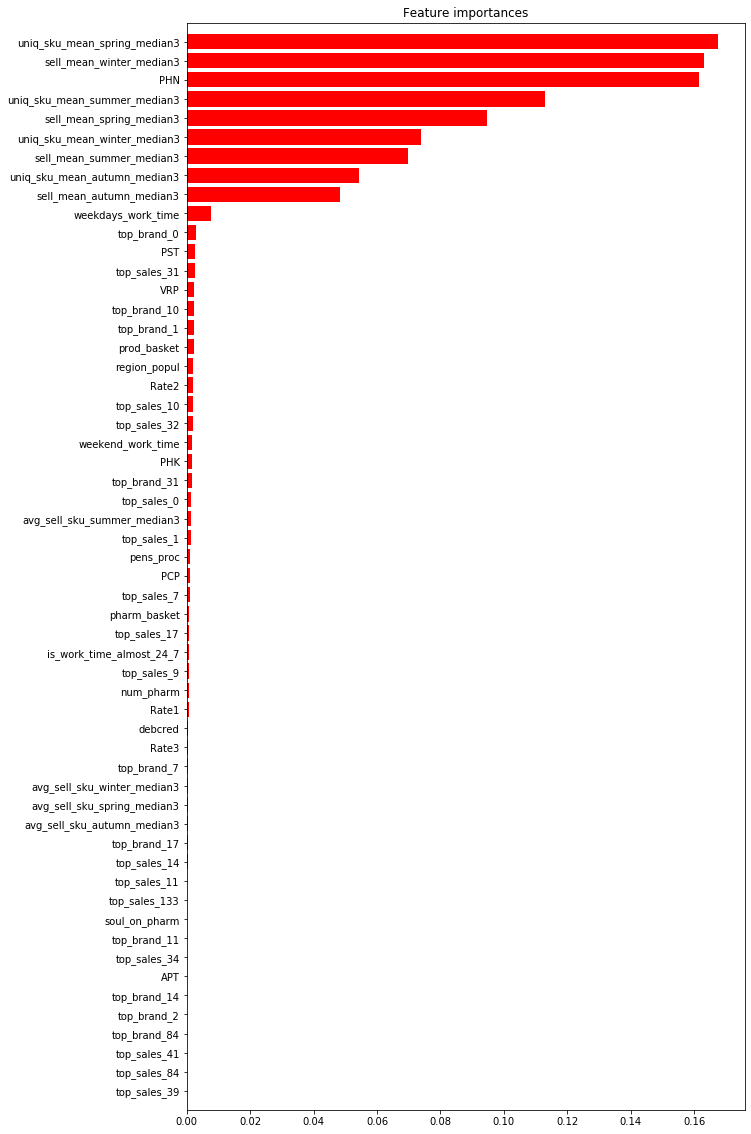

In [19]:
imp = get_and_draw_importances(X, rf_regr.feature_importances_)

Сработали признаки: суммарное кол-во сетевых аптек, все sell и uniq_sku 

... плюс суммарное время работы в рабочие дни, но не буду брать его в рассмотрение

In [20]:
col_imp = ['sell_mean_autumn_median3', 'uniq_sku_mean_autumn_median3',
           'sell_mean_summer_median3', 'uniq_sku_mean_winter_median3',
           'sell_mean_spring_median3', 'uniq_sku_mean_summer_median3', 
           'sell_mean_winter_median3', 'uniq_sku_mean_spring_median3',
           'PHN'
]

Посмотрим на зависимость Basket1 от этих признаков 

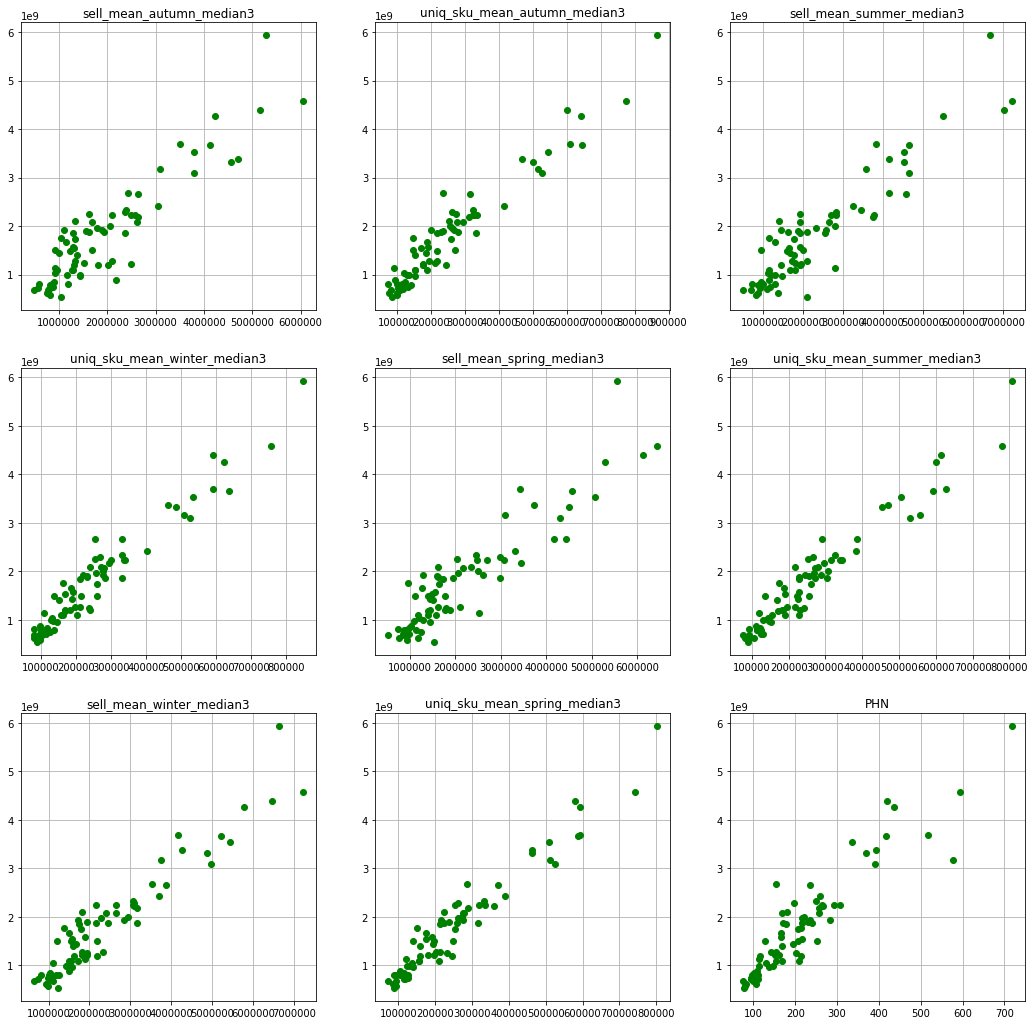

In [21]:
fig, axs = plt.subplots(3, 3, figsize=(18, 18))

k = -1
for i in range(3):
    for j in range(3):
        k += 1
        axs[i, j].plot(X[col_imp[k]], y['Basket1'], 'go')
        axs[i, j].set_title(col_imp[k])
        axs[i, j].grid()
        if k == 8:
            break

> *Везде проглядывается линейная зависимость*

# Кросс-валидация: RandomForest

In [22]:
def print_cv_results(scores):
    
    print('=============cross-validation results=============')
    print()

    r2_train_mean = np.round(scores['train_r2'].mean(), 3)
    r2_test_mean = np.round(scores['test_r2'].mean(), 3)
    r2_test_std = np.round(scores['test_r2'].std(), 4)
    print('R2:\ttrain: {0}\t\ttest: {1}\t  +- {2}'.\
          format(r2_train_mean, r2_test_mean, 2 * r2_test_std))

    rmse_train_mean = -np.round(scores['train_neg_root_mean_squared_error'].mean())
    rmse_test_mean = -np.round(scores['test_neg_root_mean_squared_error'].mean())
    rmse_test_std = np.round(scores['test_neg_root_mean_squared_error'].std())
    print('RMSE:\ttrain: {0}\ttest: {1} +- {2}'.\
          format(rmse_train_mean, rmse_test_mean, 2 * rmse_test_std))
    
    mae_train_mean = -np.round(scores['train_neg_mean_absolute_error'].mean())
    mae_test_mean = -np.round(scores['test_neg_mean_absolute_error'].mean())
    mae_test_std = np.round(scores['test_neg_mean_absolute_error'].std())
    print('MAE:\ttrain: {0}\ttest: {1} +- {2}'.\
          format(mae_train_mean, mae_test_mean, 2 * mae_test_std))

Нормализуем данные

In [23]:
scaler = RobustScaler()
scaler.fit(X[col_imp])
X_norm = pd.DataFrame(scaler.transform(X[col_imp]))
X_norm.columns = X[col_imp].columns
X_norm.head()

,sell_mean_autumn_median3,uniq_sku_mean_autumn_median3,sell_mean_summer_median3,uniq_sku_mean_winter_median3,sell_mean_spring_median3,uniq_sku_mean_summer_median3,sell_mean_winter_median3,uniq_sku_mean_spring_median3,PHN
0,1.111783,1.154566,0.880435,1.193937,1.171232,0.956618,1.131731,1.151341,0.496124
1,2.219986,1.662486,1.724281,1.705870,2.005567,1.399194,1.850074,1.618114,1.356589
2,0.613749,0.672393,0.424090,0.726942,0.946780,0.479663,0.794973,0.658980,0.356589
3,0.070100,0.075541,-0.184154,0.100333,-0.006542,-0.004205,0.162828,0.067576,-0.186047
4,-0.348829,-0.403497,-0.498060,-0.343230,-0.462587,-0.330683,-0.310231,-0.417303,0.147287


In [24]:
rf_regr = RandomForestRegressor(n_estimators=400, max_depth=3, random_state=0)

scores = cross_validate(rf_regr, 
                        X_norm, y['Basket1'], 
                        cv=10, 
                        scoring=('r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'),
                        return_train_score=True)

print_cv_results(scores)

=============cross-validation results=============

R2:	train: 0.971		test: 0.708	  +- 0.5056
RMSE:	train: 180999279.0	test: 305374087.0 +- 290658390.0
MAE:	train: 133802003.0	test: 238940063.0 +- 200480656.0


# Кросс-валидация: LinearRegression

In [25]:
lin_regr = LinearRegression()

scores = cross_validate(lin_regr, 
                        X[col_imp], y['Basket1'], 
                        cv=5, 
                        scoring=('r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'),
                        return_train_score=True)

print_cv_results(scores)

=============cross-validation results=============

R2:	train: 0.951		test: 0.717	  +- 0.4202
RMSE:	train: 234986961.0	test: 333682571.0 +- 177214844.0
MAE:	train: 189144808.0	test: 266151367.0 +- 124383966.0


> Здесь меньше переобучение! И variance!

# Linear Regression: по каждому признаку предсказываем отдельно, а затем берем среднее (Бэггинг)

In [24]:
lin_regr = LinearRegression()
kf = KFold(n_splits=5, shuffle=True)

y_ = np.array(y['Basket1'])

scores = dict()
scores['train_r2'] = []
scores['test_r2'] = []
scores['train_neg_root_mean_squared_error'] = []
scores['test_neg_root_mean_squared_error'] = []
scores['train_neg_mean_absolute_error'] = []
scores['test_neg_mean_absolute_error'] = []
scores['train_mean_absolute_percentage_error'] = []
scores['test_mean_absolute_percentage_error'] = []

for train_index, test_index in kf.split(X_norm):
    X_train, X_test = X_norm.loc[train_index, :], X_norm.loc[test_index, :]
    y_train, y_test = y_[train_index], y_[test_index]
    y_pred_train = np.zeros(y_train.size)
    y_pred_test = np.zeros(y_test.size)
    for col in col_imp:
        lin_regr.fit(np.array(X_train[col]).reshape(-1, 1), y_train)
        y_pred_test += lin_regr.predict(np.array(X_test[col]).reshape(-1, 1))
        y_pred_train += lin_regr.predict(np.array(X_train[col]).reshape(-1, 1))
    y_pred_test /= len(col_imp)
    y_pred_train /= len(col_imp)
    
    scores['test_r2'].append(metrics.r2_score(y_test, y_pred_test))
    scores['test_neg_root_mean_squared_error'].append(-metrics.mean_squared_error(y_test, y_pred_test, squared=False))
    scores['test_neg_mean_absolute_error'].append(-metrics.mean_absolute_error(y_test, y_pred_test))
    scores['test_mean_absolute_percentage_error'].append(mean_absolute_percentage_error(y_test, y_pred_test))
    
    scores['train_r2'].append(metrics.r2_score(y_train, y_pred_train))
    scores['train_neg_root_mean_squared_error'].append(-metrics.mean_squared_error(y_train, y_pred_train, squared=False))
    scores['train_neg_mean_absolute_error'].append(-metrics.mean_absolute_error(y_train, y_pred_train))
    scores['train_mean_absolute_percentage_error'].append(mean_absolute_percentage_error(y_train, y_pred_train))
 

for key in scores:
    scores[key] = np.array(scores[key])
    
print_cv_results(scores)

mape_train_mean = np.round(scores['train_mean_absolute_percentage_error'].mean(), 3)
mape_test_mean = np.round(scores['test_mean_absolute_percentage_error'].mean(), 3)
mape_test_std = np.round(scores['test_mean_absolute_percentage_error'].std(), 4)
print('MAPE:\ttrain: {0}\t\ttest: {1}\t  +- {2}'.\
          format(mape_train_mean, mape_test_mean, 2 * mape_test_std))

=============cross-validation results=============

R2:	train: 0.937		test: 0.915	  +- 0.0566
RMSE:	train: 266471419.0	test: 276709629.0 +- 77055098.0
MAE:	train: 213434778.0	test: 222984869.0 +- 51882712.0
MAPE:	train: 15.161		test: 15.535	  +- 4.833


Очень даже **not bad**)

In [25]:
y_pred = np.zeros(y_.size)

for col in col_imp:
    lin_regr.fit(np.array(X_norm[col]).reshape(-1, 1), y_)
    y_pred += lin_regr.predict(np.array(X_norm[col]).reshape(-1, 1))
    
y_pred /= len(col_imp)

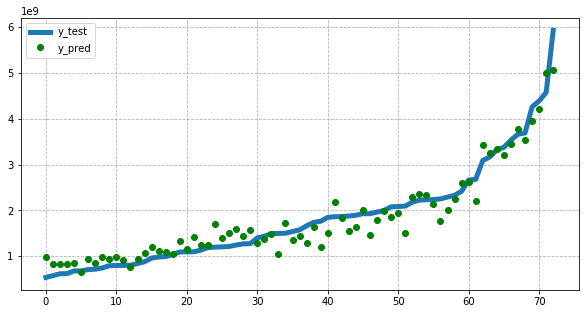

In [30]:
fig, ax = plt.subplots(figsize=(10,5))

x_plt = np.arange(0, y_.size)
indices = np.argsort(y_)

y1 = y_[indices]
y2 = y_pred[indices]
ax.plot(x_plt, y1, color='tab:blue', linewidth=5, label='y_test')
ax.plot(x_plt, y2, 'go', label='y_pred')
ax.grid(linestyle='--')
ax.legend()

*Финал для баскет1 бэггингом*

In [45]:
scaler = RobustScaler()
scaler.fit(features[col_imp])
X_norm_ = pd.DataFrame(scaler.transform(features[col_imp]))
X_norm_.columns = features[col_imp].columns
X_norm_.head()

,sell_mean_autumn_median3,uniq_sku_mean_autumn_median3,sell_mean_summer_median3,uniq_sku_mean_winter_median3,sell_mean_spring_median3,uniq_sku_mean_summer_median3,sell_mean_winter_median3,uniq_sku_mean_spring_median3,PHN
0,2.667465,2.989945,2.324112,2.941322,2.207535,2.671387,2.640392,2.586305,2.476684
1,0.863940,1.131502,0.714985,1.064873,0.535670,1.025211,0.659395,0.895970,1.025907
2,0.796471,0.736672,0.636748,0.712809,0.469861,0.745563,0.775491,0.530132,0.611399
3,0.424141,0.126415,0.346246,0.128276,0.180358,0.263498,0.231225,0.072606,0.307427
4,-0.022264,0.005417,-0.048106,0.094012,0.000149,0.203442,-0.051769,0.098223,-0.003454


In [48]:
# **********************************************
lin_regr = LinearRegression()

y_pred = np.zeros(features['Basket1'].size)
for col in col_imp:
    lin_regr.fit(np.array(X_norm[col]).reshape(-1, 1), y['Basket1'])
    y_pred += lin_regr.predict(np.array(X_norm_[col]).reshape(-1, 1))
    
basket1_pred_ver1 = y_pred / len(col_imp)
# **********************************************

# Стекинг

In [32]:
def compute_meta_feature(regr, X_train, X_test, y_train, cv, *args, **kwargs):
    """
    Вычисление метафакторов для обучаюшего и тестового множеств
    """
    # мета-фактор для обучающего мн-ва: на чем будем дальше обучать
    valid = cross_val_predict(regr, X_train, y_train, cv=cv)
    # мета-фактор для тестового мн-ва: на чем будем предсказывать
    regr.fit(X_train, y_train)
    X_meta = regr.predict(X_test)
    
    return (valid, X_meta)

In [33]:
# возьмем несколько Random Forest...
rf1 = RandomForestRegressor(n_estimators=100, max_depth=1)
rf2 = RandomForestRegressor(n_estimators=100, max_depth=2)
rf3 = RandomForestRegressor(n_estimators=25)
rf4 = RandomForestRegressor(n_estimators=50)
rf5 = RandomForestRegressor(n_estimators=400)
# ...DecisionTree
dt1 = DecisionTreeRegressor(max_depth=2)
dt2 = DecisionTreeRegressor(max_depth=3)
dt3 = DecisionTreeRegressor(max_depth=4)
dt4 = DecisionTreeRegressor(max_depth=5)
dt5 = DecisionTreeRegressor(max_depth=6)
# ...KNN
knn1 = KNeighborsRegressor(n_neighbors=7)
knn2 = KNeighborsRegressor(n_neighbors=5)
knn3 = KNeighborsRegressor(n_neighbors=9)
knn4 = KNeighborsRegressor(n_neighbors=11)
knn5 = KNeighborsRegressor(n_neighbors=3)
# ...Ridge
rg1 = Ridge(alpha=0.1)
rg2 = Ridge(alpha=0.5)
rg3 = Ridge(alpha=1.0)
rg4 = Ridge(alpha=2.0)
rg5 = Ridge(alpha=4.0)
# ...LinRegr
lr = LinearRegression()
# ...CatBoost
cb1 = CatBoostRegressor()
cb2 = CatBoostRegressor(n_estimators=100, depth=2)
cb3 = CatBoostRegressor(n_estimators=200, depth=2)
cb4 = CatBoostRegressor(n_estimators=500, depth=3, l2_leaf_reg=3)

# в кач-ве метарегрессора будем использовать Ridge
ens_model = Ridge()

# объединим все модели
models = [#rf1, rf2, rf3, rf4,
          dt1, dt2, dt3, dt4,
          knn1, knn2, knn3, knn4,
          rg1, rg2, rg3, rg4,
          lr,
          #cb1, cb2, cb3, cb4, cb5,
]

In [34]:
kf = KFold(n_splits=5, shuffle=True)

y_ = np.array(y['Basket1'])

scores = dict()
scores['train_r2'] = []
scores['test_r2'] = []
scores['train_neg_root_mean_squared_error'] = []
scores['test_neg_root_mean_squared_error'] = []
scores['train_neg_mean_absolute_error'] = []
scores['test_neg_mean_absolute_error'] = []
scores['train_mean_absolute_percentage_error'] = []
scores['test_mean_absolute_percentage_error'] = []

for train_index, test_index in kf.split(X_norm):
    X_train, X_test = X_norm.loc[train_index, :], X_norm.loc[test_index, :]
    y_train, y_test = y_[train_index], y_[test_index]
    
    y_pred_train = np.zeros(y_train.size)
    y_pred_test = np.zeros(y_test.size)
    
    # мн-во мета-факторов для обучения
    valid = np.zeros((X_train.shape[0], len(models)))
    # мн-во мета-факторов для теста
    X_meta = np.zeros((X_test.shape[0], len(models)))
    
    i = 0
    for model in models:
        (valid[:, i], X_meta[:, i]) = compute_meta_feature(model, X_train, X_test, y_train, cv=5)
        i += 1
    # метарегрессор
    ens_model.fit(valid, y_train)
    
    y_pred_test = ens_model.predict(X_meta)
    y_pred_train = ens_model.predict(valid)
    
    scores['test_r2'].append(metrics.r2_score(y_test, y_pred_test))
    scores['test_neg_root_mean_squared_error'].append(-metrics.mean_squared_error(y_test, y_pred_test, squared=False))
    scores['test_neg_mean_absolute_error'].append(-metrics.mean_absolute_error(y_test, y_pred_test))
    scores['test_mean_absolute_percentage_error'].append(mean_absolute_percentage_error(y_test, y_pred_test))
    
    scores['train_r2'].append(metrics.r2_score(y_train, y_pred_train))
    scores['train_neg_root_mean_squared_error'].append(-metrics.mean_squared_error(y_train, y_pred_train, squared=False))
    scores['train_neg_mean_absolute_error'].append(-metrics.mean_absolute_error(y_train, y_pred_train))
    scores['train_mean_absolute_percentage_error'].append(mean_absolute_percentage_error(y_train, y_pred_train))
    
    
for key in scores:
    scores[key] = np.array(scores[key])
    
print_cv_results(scores)

mape_train_mean = np.round(scores['train_mean_absolute_percentage_error'].mean(), 3)
mape_test_mean = np.round(scores['test_mean_absolute_percentage_error'].mean(), 3)
mape_test_std = np.round(scores['test_mean_absolute_percentage_error'].std(), 4)
print('MAPE:\ttrain: {0}\t\ttest: {1}\t  +- {2}'.\
          format(mape_train_mean, mape_test_mean, 2 * mape_test_std))

=============cross-validation results=============

R2:	train: 0.955		test: 0.893	  +- 0.1214
RMSE:	train: 226917797.0	test: 314553521.0 +- 127566840.0
MAE:	train: 176423016.0	test: 252407461.0 +- 87618966.0
MAPE:	train: 11.852		test: 15.998	  +- 5.8174


*Финал для баскет1 стекингом*

In [50]:
# **********************************************  
valid = np.zeros((X_norm.shape[0], len(models)))
X_meta = np.zeros((X_norm_.shape[0], len(models)))
    
i = 0
for model in models:
    (valid[:, i], X_meta[:, i]) = compute_meta_feature(model, 
                                                       X_norm[col_imp], X_norm_[col_imp], y['Basket1'], 
                                                       cv=5)
    i += 1

ens_model.fit(valid, y['Basket1'])
basket1_pred_ver2 = ens_model.predict(X_meta)
# **********************************************

# Basket2

Сразу посмотрим на значимость признаков

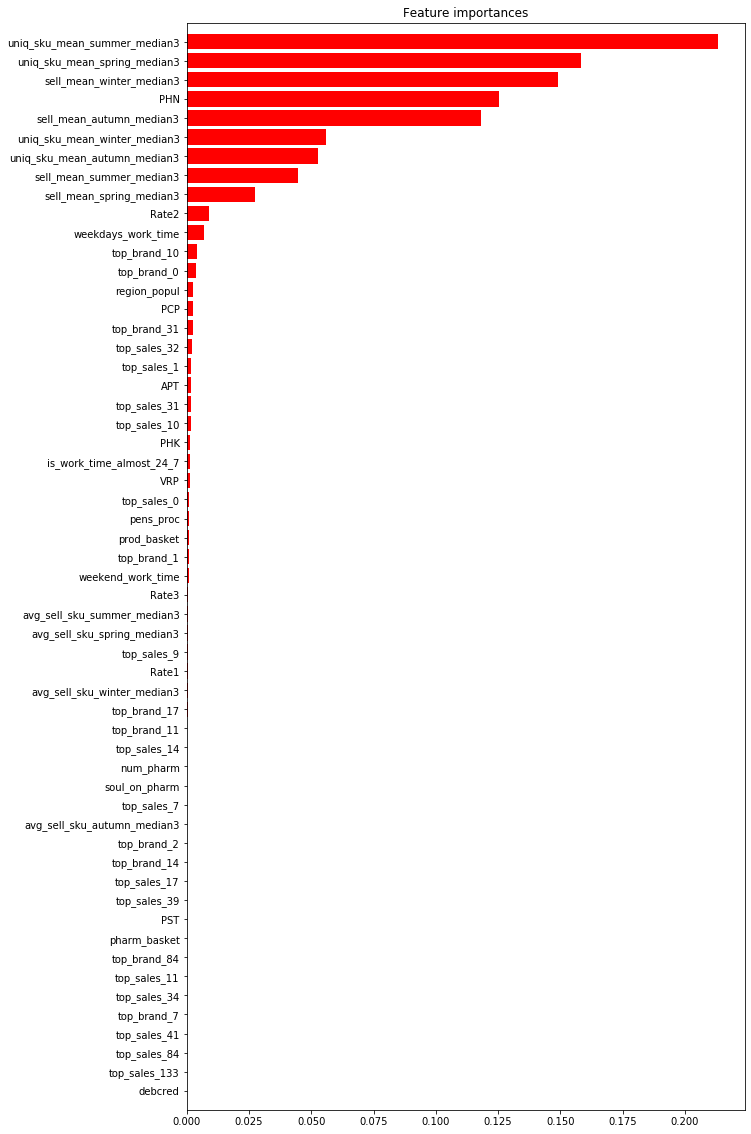

In [51]:
rf_regr = RandomForestRegressor(max_depth=3, random_state=0)
rf_regr.fit(X, y['Basket2'])
imp = get_and_draw_importances(X, rf_regr.feature_importances_)

> *Здесь точно такая же картина*

### LinearRegression (Бэггинг)

In [52]:
lin_regr = LinearRegression()
kf = KFold(n_splits=5, shuffle=True)

y_ = np.array(y['Basket2'])

scores = dict()
scores['train_r2'] = []
scores['test_r2'] = []
scores['train_neg_root_mean_squared_error'] = []
scores['test_neg_root_mean_squared_error'] = []
scores['train_neg_mean_absolute_error'] = []
scores['test_neg_mean_absolute_error'] = []
scores['train_mean_absolute_percentage_error'] = []
scores['test_mean_absolute_percentage_error'] = []

for train_index, test_index in kf.split(X_norm):
    X_train, X_test = X_norm.loc[train_index, :], X_norm.loc[test_index, :]
    y_train, y_test = y_[train_index], y_[test_index]
    y_pred_train = np.zeros(y_train.size)
    y_pred_test = np.zeros(y_test.size)
    for col in col_imp:
        lin_regr.fit(np.array(X_train[col]).reshape(-1, 1), y_train)
        y_pred_test += lin_regr.predict(np.array(X_test[col]).reshape(-1, 1))
        y_pred_train += lin_regr.predict(np.array(X_train[col]).reshape(-1, 1))
    y_pred_test /= len(col_imp)
    y_pred_train /= len(col_imp)
    
    scores['test_r2'].append(metrics.r2_score(y_test, y_pred_test))
    scores['test_neg_root_mean_squared_error'].append(-metrics.mean_squared_error(y_test, y_pred_test, squared=False))
    scores['test_neg_mean_absolute_error'].append(-metrics.mean_absolute_error(y_test, y_pred_test))
    scores['test_mean_absolute_percentage_error'].append(mean_absolute_percentage_error(y_test, y_pred_test))
    
    scores['train_r2'].append(metrics.r2_score(y_train, y_pred_train))
    scores['train_neg_root_mean_squared_error'].append(-metrics.mean_squared_error(y_train, y_pred_train, squared=False))
    scores['train_neg_mean_absolute_error'].append(-metrics.mean_absolute_error(y_train, y_pred_train))
    scores['train_mean_absolute_percentage_error'].append(mean_absolute_percentage_error(y_train, y_pred_train))
 

for key in scores:
    scores[key] = np.array(scores[key])
    
print_cv_results(scores)

mape_train_mean = np.round(scores['train_mean_absolute_percentage_error'].mean(), 3)
mape_test_mean = np.round(scores['test_mean_absolute_percentage_error'].mean(), 3)
mape_test_std = np.round(scores['test_mean_absolute_percentage_error'].std(), 4)
print('MAPE:\ttrain: {0}\t\ttest: {1}\t  +- {2}'.\
          format(mape_train_mean, mape_test_mean, 2 * mape_test_std))

=============cross-validation results=============

R2:	train: 0.947		test: 0.92	  +- 0.0972
RMSE:	train: 223958947.0	test: 225047509.0 +- 125778814.0
MAE:	train: 170367454.0	test: 175840720.0 +- 83885608.0
MAPE:	train: 12.684		test: 13.101	  +- 7.7844


Финал для баскет2 бэггингом

In [53]:
# **********************************************
lin_regr = LinearRegression()

y_pred = np.zeros(features['Basket2'].size)
for col in col_imp:
    lin_regr.fit(np.array(X_norm[col]).reshape(-1, 1), y['Basket2'])
    y_pred += lin_regr.predict(np.array(X_norm_[col]).reshape(-1, 1))
    
basket2_pred_ver1 = y_pred / len(col_imp)
# **********************************************

### Стекинг

In [39]:
# возьмем несколько Random Forest...
rf1 = RandomForestRegressor(n_estimators=100, max_depth=1)
rf2 = RandomForestRegressor(n_estimators=100, max_depth=2)
rf3 = RandomForestRegressor(n_estimators=25)
rf4 = RandomForestRegressor(n_estimators=50)
rf5 = RandomForestRegressor(n_estimators=400)
# ...DecisionTree
dt1 = DecisionTreeRegressor(max_depth=2)
dt2 = DecisionTreeRegressor(max_depth=3)
dt3 = DecisionTreeRegressor(max_depth=4)
dt4 = DecisionTreeRegressor(max_depth=5)
dt5 = DecisionTreeRegressor(max_depth=6)
# ...KNN
knn1 = KNeighborsRegressor(n_neighbors=7)
knn2 = KNeighborsRegressor(n_neighbors=5)
knn3 = KNeighborsRegressor(n_neighbors=9)
knn4 = KNeighborsRegressor(n_neighbors=11)
knn5 = KNeighborsRegressor(n_neighbors=3)
# ...Ridge
rg1 = Ridge(alpha=0.1)
rg2 = Ridge(alpha=0.5)
rg3 = Ridge(alpha=1.0)
rg4 = Ridge(alpha=2.0)
rg5 = Ridge(alpha=4.0)
# ...LinRegr
lr = LinearRegression()
# ...CatBoost
cb1 = CatBoostRegressor()
cb2 = CatBoostRegressor(n_estimators=100, depth=2)
cb3 = CatBoostRegressor(n_estimators=200, depth=2)
cb4 = CatBoostRegressor(n_estimators=500, depth=3, l2_leaf_reg=3)

# в кач-ве метарегрессора будем использовать Ridge
ens_model = Ridge()

# объединим все модели
models = [#rf1, rf2, rf3, rf4,
          dt1, dt2, dt3, dt4,
          knn1, knn2, knn3, knn4,
          rg1, rg2, rg3, rg4,
          lr,
          #cb1, cb2, cb3, cb4, cb5,
]

In [40]:
kf = KFold(n_splits=5, shuffle=True)

y_ = np.array(y['Basket2'])

scores = dict()
scores['train_r2'] = []
scores['test_r2'] = []
scores['train_neg_root_mean_squared_error'] = []
scores['test_neg_root_mean_squared_error'] = []
scores['train_neg_mean_absolute_error'] = []
scores['test_neg_mean_absolute_error'] = []
scores['train_mean_absolute_percentage_error'] = []
scores['test_mean_absolute_percentage_error'] = []

for train_index, test_index in kf.split(X_norm):
    X_train, X_test = X_norm.loc[train_index, :], X_norm.loc[test_index, :]
    y_train, y_test = y_[train_index], y_[test_index]
    
    y_pred_train = np.zeros(y_train.size)
    y_pred_test = np.zeros(y_test.size)
    
    # мн-во мета-факторов для обучения
    valid = np.zeros((X_train.shape[0], len(models)))
    # мн-во мета-факторов для теста
    X_meta = np.zeros((X_test.shape[0], len(models)))
    
    i = 0
    for model in models:
        (valid[:, i], X_meta[:, i]) = compute_meta_feature(model, X_train, X_test, y_train, cv=5)
        i += 1
    # метарегрессор
    ens_model.fit(valid, y_train)
    
    y_pred_test = ens_model.predict(X_meta)
    y_pred_train = ens_model.predict(valid)
    
    scores['test_r2'].append(metrics.r2_score(y_test, y_pred_test))
    scores['test_neg_root_mean_squared_error'].append(-metrics.mean_squared_error(y_test, y_pred_test, squared=False))
    scores['test_neg_mean_absolute_error'].append(-metrics.mean_absolute_error(y_test, y_pred_test))
    scores['test_mean_absolute_percentage_error'].append(mean_absolute_percentage_error(y_test, y_pred_test))
    
    scores['train_r2'].append(metrics.r2_score(y_train, y_pred_train))
    scores['train_neg_root_mean_squared_error'].append(-metrics.mean_squared_error(y_train, y_pred_train, squared=False))
    scores['train_neg_mean_absolute_error'].append(-metrics.mean_absolute_error(y_train, y_pred_train))
    scores['train_mean_absolute_percentage_error'].append(mean_absolute_percentage_error(y_train, y_pred_train))
    
    
for key in scores:
    scores[key] = np.array(scores[key])
    
print_cv_results(scores)

mape_train_mean = np.round(scores['train_mean_absolute_percentage_error'].mean(), 3)
mape_test_mean = np.round(scores['test_mean_absolute_percentage_error'].mean(), 3)
mape_test_std = np.round(scores['test_mean_absolute_percentage_error'].std(), 4)
print('MAPE:\ttrain: {0}\t\ttest: {1}\t  +- {2}'.\
          format(mape_train_mean, mape_test_mean, 2 * mape_test_std))

=============cross-validation results=============

R2:	train: 0.964		test: 0.924	  +- 0.0442
RMSE:	train: 183454800.0	test: 253596925.0 +- 126619824.0
MAE:	train: 141880018.0	test: 187692009.0 +- 57847290.0
MAPE:	train: 10.563		test: 13.118	  +- 4.381


*Финал для баскет2 стекингом*

In [54]:
# **********************************************  
valid = np.zeros((X_norm.shape[0], len(models)))
X_meta = np.zeros((X_norm_.shape[0], len(models)))
    
i = 0
for model in models:
    (valid[:, i], X_meta[:, i]) = compute_meta_feature(model, 
                                                       X_norm[col_imp], X_norm_[col_imp], y['Basket2'], 
                                                       cv=5)
    i += 1

ens_model.fit(valid, y['Basket2'])
basket2_pred_ver2 = ens_model.predict(X_meta)
# **********************************************

# Basket3

Добавим предсказания первых двух баскетов, вдруг даст прирост качества

In [55]:
features['basket1_pred'] = basket1_pred_ver2
features['basket2_pred'] = basket2_pred_ver2

In [57]:
col_full = ['VRP', 
            'APT', 'PCP', 'PHK', 'PHN', 'PST',
            'top_brand_0', 'top_brand_1', 'top_brand_2', 'top_brand_7',
            'top_brand_10', 'top_brand_11', 'top_brand_14', 'top_brand_17',
            'top_brand_31', 'top_brand_84',
            'top_sales_0', 'top_sales_1', 'top_sales_7', 'top_sales_9',
            'top_sales_10', 'top_sales_11', 'top_sales_14', 'top_sales_17',
            'top_sales_31', 'top_sales_32', 'top_sales_34', 'top_sales_39', 
            'top_sales_41', 'top_sales_84', 'top_sales_133', 
            'Rate1', 'Rate2', 'Rate3', 
            'weekdays_work_time', 'weekend_work_time', 'is_work_time_almost_24_7', 
            #'uniq_sku_mean_median3', 
            'uniq_sku_mean_summer_median3', 'uniq_sku_mean_autumn_median3',
            'uniq_sku_mean_winter_median3', 'uniq_sku_mean_spring_median3', 
            #'sell_mean_median3', 
            'sell_mean_summer_median3', 'sell_mean_autumn_median3', 
            'sell_mean_winter_median3', 'sell_mean_spring_median3', 
            #'avg_sell_sku_median3',
            'avg_sell_sku_summer_median3', 'avg_sell_sku_autumn_median3', 
            'avg_sell_sku_winter_median3', 'avg_sell_sku_spring_median3',
            'debcred', 'pens_proc', 'prod_basket', 'pharm_basket',
            'num_pharm', 'region_popul', 'soul_on_pharm',
            'basket1_pred', 'basket2_pred',
]

In [58]:
train = features.loc[brickcode_ok, :]
X = train[col_full]
y = train[['Basket1', 'Basket2', 'Basket3']]

Распределение признаков

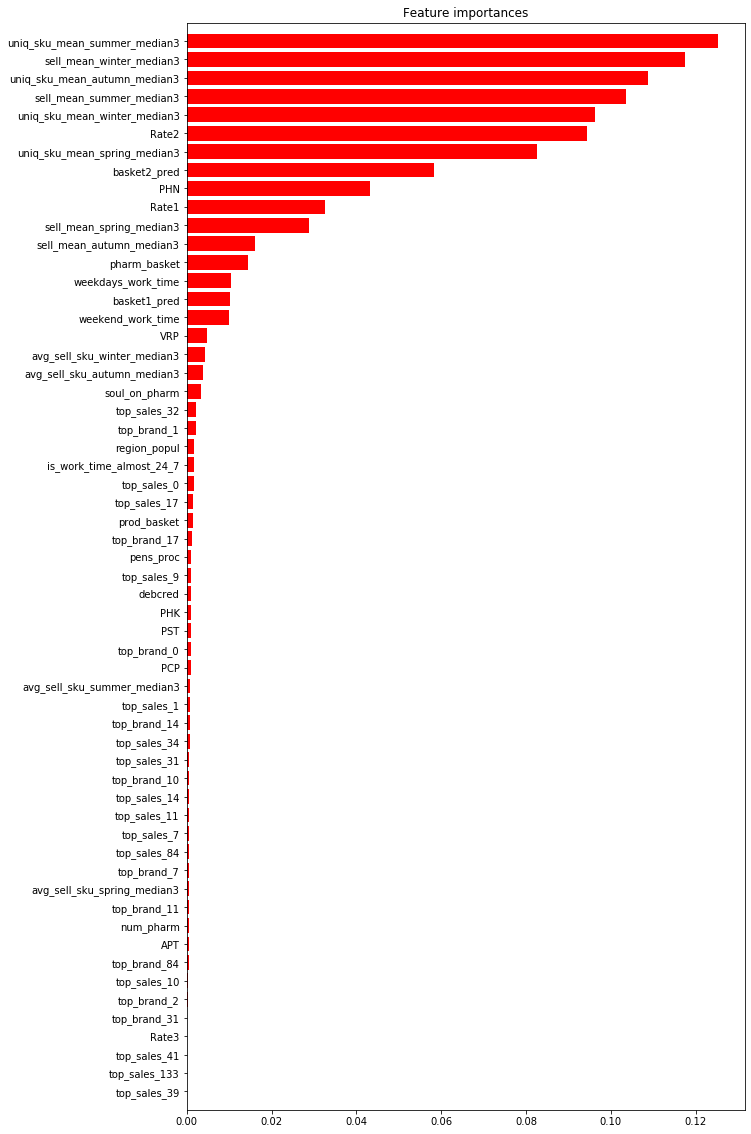

In [59]:
rf_regr = RandomForestRegressor(max_depth=3, random_state=0)
rf_regr.fit(X, y['Basket3'])
imp = get_and_draw_importances(X, rf_regr.feature_importances_)

In [60]:
col_imp = ['sell_mean_autumn_median3', 'uniq_sku_mean_autumn_median3',
           'sell_mean_summer_median3', 'uniq_sku_mean_winter_median3',
           'sell_mean_spring_median3', 'uniq_sku_mean_summer_median3', 
           'sell_mean_winter_median3', 'uniq_sku_mean_spring_median3',
           'PHN',
           'Rate1', 'Rate2', 
           'weekdays_work_time', 'weekend_work_time',
           'basket1_pred', 'basket2_pred'
]

Посмотрим на зависимость Basket3 от этих признаков

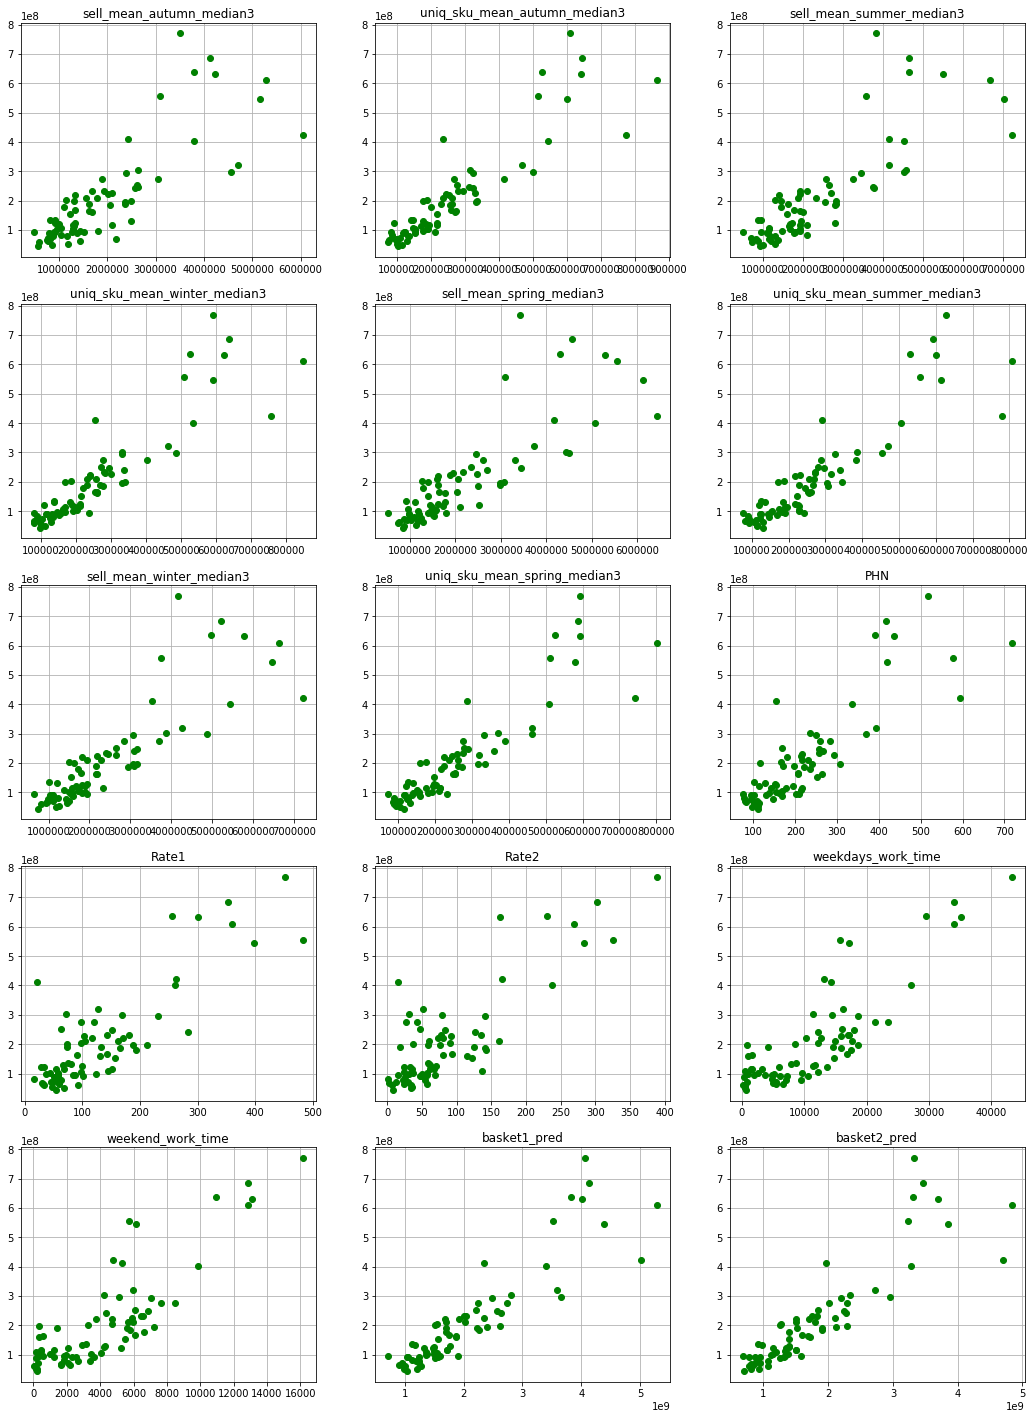

In [61]:
fig, axs = plt.subplots(5, 3, figsize=(18, 25))

k = -1
for i in range(5):
    for j in range(3):
        k += 1
        axs[i, j].plot(X[col_imp[k]], y['Basket3'], 'go')
        axs[i, j].set_title(col_imp[k])
        axs[i, j].grid()
        if k == 14:
            break

### LinearRegression: Бэггинг

In [62]:
scaler = RobustScaler()
scaler.fit(X[col_imp])
X_norm = pd.DataFrame(scaler.transform(X[col_imp]))
X_norm.columns = X[col_imp].columns
X_norm.head()

,sell_mean_autumn_median3,uniq_sku_mean_autumn_median3,sell_mean_summer_median3,uniq_sku_mean_winter_median3,sell_mean_spring_median3,uniq_sku_mean_summer_median3,sell_mean_winter_median3,uniq_sku_mean_spring_median3,PHN,Rate1,Rate2,weekdays_work_time,weekend_work_time,basket1_pred,basket2_pred
0,1.111783,1.154566,0.880435,1.193937,1.171232,0.956618,1.131731,1.151341,0.496124,0.221154,-0.197531,1.072701,1.057650,0.958550,0.774175
1,2.219986,1.662486,1.724281,1.705870,2.005567,1.399194,1.850074,1.618114,1.356589,0.692308,0.246914,0.321828,0.314505,1.816041,1.417878
2,0.613749,0.672393,0.424090,0.726942,0.946780,0.479663,0.794973,0.658980,0.356589,0.875000,0.209877,0.667901,0.772727,0.643011,0.610686
3,0.070100,0.075541,-0.184154,0.100333,-0.006542,-0.004205,0.162828,0.067576,-0.186047,-0.221154,-0.506173,0.339859,0.418441,0.000000,0.026451
4,-0.348829,-0.403497,-0.498060,-0.343230,-0.462587,-0.330683,-0.310231,-0.417303,0.147287,0.451923,0.962963,-0.853269,-0.788470,-0.320568,-0.286578


In [65]:
lin_regr = LinearRegression()
kf = KFold(n_splits=5, shuffle=True)

y_ = np.array(y['Basket3'])

scores = dict()
scores['train_r2'] = []
scores['test_r2'] = []
scores['train_neg_root_mean_squared_error'] = []
scores['test_neg_root_mean_squared_error'] = []
scores['train_neg_mean_absolute_error'] = []
scores['test_neg_mean_absolute_error'] = []
scores['train_mean_absolute_percentage_error'] = []
scores['test_mean_absolute_percentage_error'] = []

for train_index, test_index in kf.split(X_norm):
    X_train, X_test = X_norm.loc[train_index, :], X_norm.loc[test_index, :]
    y_train, y_test = y_[train_index], y_[test_index]
    y_pred_train = np.zeros(y_train.size)
    y_pred_test = np.zeros(y_test.size)
    for col in col_imp:
        lin_regr.fit(np.array(X_train[col]).reshape(-1, 1), y_train)
        y_pred_test += lin_regr.predict(np.array(X_test[col]).reshape(-1, 1))
        y_pred_train += lin_regr.predict(np.array(X_train[col]).reshape(-1, 1))
    y_pred_test /= len(col_imp)
    y_pred_train /= len(col_imp)
    
    scores['test_r2'].append(metrics.r2_score(y_test, y_pred_test))
    scores['test_neg_root_mean_squared_error'].append(-metrics.mean_squared_error(y_test, y_pred_test, squared=False))
    scores['test_neg_mean_absolute_error'].append(-metrics.mean_absolute_error(y_test, y_pred_test))
    scores['test_mean_absolute_percentage_error'].append(mean_absolute_percentage_error(y_test, y_pred_test))
    
    scores['train_r2'].append(metrics.r2_score(y_train, y_pred_train))
    scores['train_neg_root_mean_squared_error'].append(-metrics.mean_squared_error(y_train, y_pred_train, squared=False))
    scores['train_neg_mean_absolute_error'].append(-metrics.mean_absolute_error(y_train, y_pred_train))
    scores['train_mean_absolute_percentage_error'].append(mean_absolute_percentage_error(y_train, y_pred_train))
 
for key in scores:
    scores[key] = np.array(scores[key])
    
print_cv_results(scores)

mape_train_mean = np.round(scores['train_mean_absolute_percentage_error'].mean(), 3)
mape_test_mean = np.round(scores['test_mean_absolute_percentage_error'].mean(), 3)
mape_test_std = np.round(scores['test_mean_absolute_percentage_error'].std(), 4)
print('MAPE:\ttrain: {0}\t\ttest: {1}\t  +- {2}'.\
          format(mape_train_mean, mape_test_mean, 2 * mape_test_std))

=============cross-validation results=============

R2:	train: 0.854		test: 0.842	  +- 0.0868
RMSE:	train: 62612765.0	test: 62949387.0 +- 43429006.0
MAE:	train: 41601900.0	test: 42673810.0 +- 20831378.0
MAPE:	train: 22.19		test: 22.403	  +- 1.2126


*Финал для баскет3 бэггингом*

In [66]:
scaler = RobustScaler()
scaler.fit(features[col_imp])
X_norm_ = pd.DataFrame(scaler.transform(features[col_imp]))
X_norm_.columns = features[col_imp].columns
X_norm_.head()

,sell_mean_autumn_median3,uniq_sku_mean_autumn_median3,sell_mean_summer_median3,uniq_sku_mean_winter_median3,sell_mean_spring_median3,uniq_sku_mean_summer_median3,sell_mean_winter_median3,uniq_sku_mean_spring_median3,PHN,Rate1,Rate2,weekdays_work_time,weekend_work_time,basket1_pred,basket2_pred
0,2.667465,2.989945,2.324112,2.941322,2.207535,2.671387,2.640392,2.586305,2.476684,1.732323,1.722846,2.679801,2.849441,2.747360,2.506830
1,0.863940,1.131502,0.714985,1.064873,0.535670,1.025211,0.659395,0.895970,1.025907,0.803030,0.808989,-0.475401,-0.437185,0.699103,0.854555
2,0.796471,0.736672,0.636748,0.712809,0.469861,0.745563,0.775491,0.530132,0.611399,1.186869,1.363296,0.816381,0.866021,0.637488,0.634358
3,0.424141,0.126415,0.346246,0.128276,0.180358,0.263498,0.231225,0.072606,0.307427,0.186869,0.284644,-0.209581,-0.159545,0.282654,0.287384
4,-0.022264,0.005417,-0.048106,0.094012,0.000149,0.203442,-0.051769,0.098223,-0.003454,0.227273,-0.374532,0.284028,0.206621,-0.011351,-0.019467


In [67]:
# **********************************************
lin_regr = LinearRegression()

y_pred = np.zeros(features['Basket3'].size)
for col in col_imp:
    lin_regr.fit(np.array(X_norm[col]).reshape(-1, 1), y['Basket3'])
    y_pred += lin_regr.predict(np.array(X_norm_[col]).reshape(-1, 1))
    
basket3_pred_ver1 = y_pred / len(col_imp)
# **********************************************

### Стекинг

In [76]:
# возьмем несколько Random Forest...
rf1 = RandomForestRegressor(n_estimators=100, max_depth=1)
rf2 = RandomForestRegressor(n_estimators=100, max_depth=2)
rf3 = RandomForestRegressor(n_estimators=25)
rf4 = RandomForestRegressor(n_estimators=50)
rf5 = RandomForestRegressor(n_estimators=400)
# ...DecisionTree
dt1 = DecisionTreeRegressor(max_depth=2)
dt2 = DecisionTreeRegressor(max_depth=3)
dt3 = DecisionTreeRegressor(max_depth=4)
dt4 = DecisionTreeRegressor(max_depth=5)
dt5 = DecisionTreeRegressor(max_depth=6)
# ...KNN
knn1 = KNeighborsRegressor(n_neighbors=7)
knn2 = KNeighborsRegressor(n_neighbors=5)
knn3 = KNeighborsRegressor(n_neighbors=9)
knn4 = KNeighborsRegressor(n_neighbors=11)
knn5 = KNeighborsRegressor(n_neighbors=3)
# ...Ridge
rg1 = Ridge(alpha=0.1)
rg2 = Ridge(alpha=0.5)
rg3 = Ridge(alpha=1.0)
rg4 = Ridge(alpha=2.0)
rg5 = Ridge(alpha=4.0)
# ...LinRegr
lr = LinearRegression()
# ...CatBoost
cb1 = CatBoostRegressor()
cb2 = CatBoostRegressor(n_estimators=100, depth=2)
cb3 = CatBoostRegressor(n_estimators=200, depth=2)
cb4 = CatBoostRegressor(n_estimators=500, depth=3, l2_leaf_reg=3)

# в кач-ве метаклассификатора будем использовать Ridge
ens_model = Ridge()

# объединим все модели
models = [#rf1, rf2, rf3, rf4, 
          dt1, dt2, dt3, dt4,
          knn1, knn2, knn3, knn4,
          rg1, rg2, rg3, rg4,
          lr,
]

In [78]:
kf = KFold(n_splits=5, shuffle=True)

y_ = np.array(y['Basket3'])

scores = dict()
scores['train_r2'] = []
scores['test_r2'] = []
scores['train_neg_root_mean_squared_error'] = []
scores['test_neg_root_mean_squared_error'] = []
scores['train_neg_mean_absolute_error'] = []
scores['test_neg_mean_absolute_error'] = []
scores['train_mean_absolute_percentage_error'] = []
scores['test_mean_absolute_percentage_error'] = []

for train_index, test_index in kf.split(X_norm):
    X_train, X_test = X_norm.loc[train_index, :], X_norm.loc[test_index, :]
    y_train, y_test = y_[train_index], y_[test_index]
    
    y_pred_train = np.zeros(y_train.size)
    y_pred_test = np.zeros(y_test.size)
    
    # мн-во мета-факторов для обучения
    valid = np.zeros((X_train.shape[0], len(models)))
    # мн-во мета-факторов для теста
    X_meta = np.zeros((X_test.shape[0], len(models)))
    
    i = 0
    for model in models:
        (valid[:, i], X_meta[:, i]) = compute_meta_feature(model, X_train, X_test, y_train, cv=5)
        i += 1
    # метарегрессор
    ens_model.fit(valid, y_train)
    
    y_pred_test = ens_model.predict(X_meta)
    y_pred_train = ens_model.predict(valid)
    
    scores['test_r2'].append(metrics.r2_score(y_test, y_pred_test))
    scores['test_neg_root_mean_squared_error'].append(-metrics.mean_squared_error(y_test, y_pred_test, squared=False))
    scores['test_neg_mean_absolute_error'].append(-metrics.mean_absolute_error(y_test, y_pred_test))
    scores['test_mean_absolute_percentage_error'].append(mean_absolute_percentage_error(y_test, y_pred_test))
    
    scores['train_r2'].append(metrics.r2_score(y_train, y_pred_train))
    scores['train_neg_root_mean_squared_error'].append(-metrics.mean_squared_error(y_train, y_pred_train, squared=False))
    scores['train_neg_mean_absolute_error'].append(-metrics.mean_absolute_error(y_train, y_pred_train))
    scores['train_mean_absolute_percentage_error'].append(mean_absolute_percentage_error(y_train, y_pred_train))
    
    
for key in scores:
    scores[key] = np.array(scores[key])
    
print_cv_results(scores)

mape_train_mean = np.round(scores['train_mean_absolute_percentage_error'].mean(), 3)
mape_test_mean = np.round(scores['test_mean_absolute_percentage_error'].mean(), 3)
mape_test_std = np.round(scores['test_mean_absolute_percentage_error'].std(), 4)
print('MAPE:\ttrain: {0}\t\ttest: {1}\t  +- {2}'.\
          format(mape_train_mean, mape_test_mean, 2 * mape_test_std))

=============cross-validation results=============

R2:	train: 0.931		test: 0.793	  +- 0.2526
RMSE:	train: 43060854.0	test: 66220152.0 +- 45700284.0
MAE:	train: 32218081.0	test: 44844803.0 +- 25250280.0
MAPE:	train: 20.129		test: 24.381	  +- 16.5526


*Финал для баскет3 стекингом*

In [79]:
# **********************************************  
valid = np.zeros((X_norm.shape[0], len(models)))
X_meta = np.zeros((X_norm_.shape[0], len(models)))
    
i = 0
for model in models:
    (valid[:, i], X_meta[:, i]) = compute_meta_feature(model, 
                                                       X_norm[col_imp], X_norm_[col_imp], y['Basket3'], 
                                                       cv=5)
    i += 1

ens_model.fit(valid, y['Basket3'])
basket3_pred_ver2 = ens_model.predict(X_meta)
# **********************************************

# Формирование финальной таблицы

In [84]:
features['basket1_pred_ver1'] = basket1_pred_ver1
features['basket1_pred_ver2'] = basket1_pred_ver2
features['basket2_pred_ver1'] = basket2_pred_ver1
features['basket2_pred_ver2'] = basket2_pred_ver2
features['basket3_pred_ver1'] = basket3_pred_ver1
features['basket3_pred_ver2'] = basket3_pred_ver2

In [86]:
basket_prediction_for_regions_ver1 = pd.DataFrame()
basket_prediction_for_regions_ver1['BrickCode'] = features.BrickCode
basket_prediction_for_regions_ver1['Basket1'] = features.Basket1
basket_prediction_for_regions_ver1['Basket2'] = features.Basket2
basket_prediction_for_regions_ver1['Basket3'] = features.Basket3

for bc in brickcode_bad:
    basket_prediction_for_regions_ver1.loc[basket_prediction_for_regions_ver1.BrickCode == bc, 'Basket1'] =\
        features[features.BrickCode == bc]['basket1_pred_ver1']
    basket_prediction_for_regions_ver1.loc[basket_prediction_for_regions_ver1.BrickCode == bc, 'Basket2'] =\
        features[features.BrickCode == bc]['basket2_pred_ver1']
    basket_prediction_for_regions_ver1.loc[basket_prediction_for_regions_ver1.BrickCode == bc, 'Basket3'] =\
        features[features.BrickCode == bc]['basket3_pred_ver1']

In [92]:
basket_prediction_for_regions_ver2 = pd.DataFrame()
basket_prediction_for_regions_ver2['BrickCode'] = features.BrickCode
basket_prediction_for_regions_ver2['Basket1'] = features.Basket1
basket_prediction_for_regions_ver2['Basket2'] = features.Basket2
basket_prediction_for_regions_ver2['Basket3'] = features.Basket3

for bc in brickcode_bad:
    basket_prediction_for_regions_ver2.loc[basket_prediction_for_regions_ver2.BrickCode == bc, 'Basket1'] =\
        features[features.BrickCode == bc]['basket1_pred_ver2']
    basket_prediction_for_regions_ver2.loc[basket_prediction_for_regions_ver2.BrickCode == bc, 'Basket2'] =\
        features[features.BrickCode == bc]['basket2_pred_ver2']
    basket_prediction_for_regions_ver2.loc[basket_prediction_for_regions_ver2.BrickCode == bc, 'Basket3'] =\
        features[features.BrickCode == bc]['basket3_pred_ver2']

### Запись в файл

In [93]:
basket_prediction_for_regions_ver1.to_excel("C:\\Users\\dgalk\\shad_final_project\\basket_prediction_for_regions_ver1.xlsx", 
                                            index=False)

In [94]:
basket_prediction_for_regions_ver2.to_excel("C:\\Users\\dgalk\\shad_final_project\\basket_prediction_for_regions_ver2.xlsx", 
                                            index=False)